# Divergence of HCN relative to neutral expectation

- For each city, test whether urban-rural divergence in HCN is greater than expected based on null distribution of randomly selected 4fold degenerate sites with a similar genetic architecture as HCN. 

In [1]:
library(data.table)
library(tidyverse)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()


In [167]:
load_maf <- function(path){
    base <- basename(path)
    city = str_split(base, '_[u|r]_', simplify = TRUE)[1]
    habitat = str_extract(base, pattern = '(?<=_)[r|u]')
    
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        filter(nInd >= 10) %>%
        mutate(city = city, 
               habitat = habitat,
               pos = paste(chromo, position, sep = '_')) %>%
    dplyr::select(city, habitat, pos, everything(), -'pK-EM', -ref, -anc, -chromo, -position) %>%
    return(df)
}

intersect_positions <- function(df){
    
    df_out <- df %>%
        filter(pos %in% (df %>% 
                         group_split(habitat) %>% 
                         map(~pull(., pos)) %>% 
                         reduce(intersect)))
    return(df_out)
}

estimate_mock_hcn <- function(pA, pB){
    qA <- 1 - pA
    qB <- 1 - pB
    acn <- qA^2 + qB^2 - (qA^2 * qB^2)
    hcn <- 1 - acn
    return(hcn)
}

hudson_fst <- function(p_u, p_r, n_u, n_r){
    
    # Numerator
    a <- (p_u - p_r)^2
    b <- (p_u * (1 - p_u)) / (n_u - 1)
    c <- (p_r * (1 - p_r)) / (n_r - 1)
    num <- a - b - c
    
    # Denominator
    d <- p_u * (1 - p_r)
    e <- p_r * (1 - p_u)
    denom <- d + e
    
    fst <- num / denom
    
    return(fst)
}

dxy <- function(p_u, p_r){
    
    
    dxy <- (p_u * (1 - p_r)) + (p_r * (1 - p_u))
    return(dxy)
}

simulate_null <- function(df, stat, nreps = 1000){
    
    city <- df %>% pull(city) %>% unique()
    stats_out <- c()
    
    for(i in 1:nreps){
        # Randomly sample 2 sites
        random_sites <- sample_n(df, size = 2)

        # Get mock "Ac" and "Li" allele frequencies in each habitat
        # Get sample sizes too
        Ac_r <- random_sites[1, 'knownEM_r'] %>% pull()
        Li_r <- random_sites[2, 'knownEM_r'] %>% pull()
        Ac_u <- random_sites[1, 'knownEM_u'] %>% pull()
        Li_u <- random_sites[2, 'knownEM_u'] %>% pull()

        # Habitat sample size will be mean of mock Ac and Li sample sizes
        r_ss <- mean(random_sites[1, 'nInd_r']  %>% pull(), random_sites[2, 'nInd_r'] %>% pull())
        u_ss <- mean(random_sites[1, 'nInd_u']  %>% pull(), random_sites[2, 'nInd_u'] %>% pull())

        # Estimate mock HCN frequency in each habitat
        r_hcn <- estimate_mock_hcn(Ac_r, Li_r)
        u_hcn <- estimate_mock_hcn(Ac_u, Li_u)

        # Estimate differentiation stats as measure of differentiation in mock HCN
        fst <- hudson_fst(u_hcn, r_hcn, u_ss, r_ss)
        dxy <- dxy(u_hcn, r_hcn)
        diff <- u_hcn - r_hcn

        if(stat == 'fst'){
            stat = fst
        }else if(stat == 'dxy'){
            stat = dxy
        }else{
            stat = diff
        }
        stats_out[i] <- stat
    }
    
    out <- tibble(city = city, rep = 1:nreps, stat = stats_out)
    return(out)
}

load_plant_data <- function(city){
    inpath <- '../../phenotypic-analyses/data/clean/individualPlant_allCities/'
    full_path <- paste0(inpath, city, '.csv')
    df <- suppressMessages(read_csv(full_path)) %>%
        dplyr::select(city, population, plant, hcn_result) %>%
        mutate(population = as.character(population),
               plant = as.character(plant))
    if(city == 'Armidale'){
        df <- separate(df, plant, sep = '-', into = c('population', 'plant'))
    }
    return(df) 
}

 # Function to estimate P-values
permutation_pval <- function(df){
    city <- df %>% pull(city) %>% unique()
    obs_val <- df %>% filter(is.na(rep)) %>% pull('stat')
    perm_val <- df %>% filter(!(is.na(rep))) %>% pull('stat')
    pval <- sum(abs(perm_val) >= abs(obs_val)) / length(perm_val)
    df_out <- data.frame(city = city, pval = pval)
    return(df_out)
}

In [6]:
# Load all 4fold allele frequencies as single dataframe
inpath <- '../../../results/angsd/afs/by_city/'
df_afs <- list.files(inpath, full.names = TRUE, recursive = TRUE, pattern = '*.mafs.gz') %>%
    map_dfr(., load_maf)

In [7]:
# Get sites common to urban and rural habitats, seaprately for each city
# Pivot data for easier random site selection
# Use only sites with same major and minor alleles
df_afs_inter <- df_afs %>%
    group_split(city) %>%
    map_dfr(., intersect_positions) %>%
    pivot_wider(names_from = 'habitat', values_from = c('knownEM', 'nInd', 'minor')) %>%
    filter(minor_u == minor_r)  
head(df_afs_inter)

city,pos,major,knownEM_r,knownEM_u,nInd_r,nInd_u,minor_r,minor_u
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Albuquerque,CM019101.1_17063,A,0.522677,0.633789,13,10,C,C
Albuquerque,CM019101.1_17462,T,0.144811,0.157838,13,13,A,A
Albuquerque,CM019101.1_19481,C,0.741929,0.661749,13,13,A,A
Albuquerque,CM019101.1_19520,G,0.746196,0.806513,13,13,A,A
Albuquerque,CM019101.1_19553,A,0.638462,0.828019,12,10,T,T
Albuquerque,CM019101.1_47203,C,0.880891,0.965221,23,19,G,G


In [109]:
# Load in sample sheet
# Load binomial regression model summaries and predict urban and rural HCN
sample_sheet <- suppressMessages(read_delim('../resources/glue_pc_sampleSheet.txt', delim = '\t'))
cline_models <- suppressMessages(read_csv('../../phenotypic-analyses/analysis/supplementary-tables/allCities_logisticReg_coefs.csv')) %>% 
    filter(city %in% sample_sheet$city) %>% 
    mutate(hcn_u = exp(yint_Dist + betaLog_Dist*0) / (1 + (exp(yint_Dist + betaLog_Dist*0))),
           hcn_r = exp(yint_Dist + betaLog_Dist*1) / (1 + (exp(yint_Dist + betaLog_Dist*1)))) %>% 
    mutate(diff = hcn_u - hcn_r) %>% 
    mutate(sig = ifelse(pvalLog_Dist < 0.05, 'Yes', 'No')) %>% 
    dplyr::select(city, sig, hcn_u, hcn_r, diff)

In [9]:
 # Data frame with indivudual plant phenotype data for sequenced cities
cities <- df_afs %>% pull(city) %>% unique()
df_allPlants <- map_dfr(cities, load_plant_data) %>%
    mutate(city = case_when(city == 'Toronto' ~ 's',
                            city == 'Buenos_Aires' ~ 'Buen_Air',
                            city == 'Thessaloniki' ~ 'Thessa', 
                            city == 'Christchurch' ~ 'Chrchurch', TRUE ~ city)) %>%
    mutate(sample = paste(city, population, plant, sep = '_')) %>%
    dplyr::select(sample, hcn_result)

In [26]:
# Data frame containing only individual plants for which we have sequence data 
# NOTE: There are about 100 samples with sample ID issues that are excluded here. 
# This shouldn't affect much 
# Not using this right now. Using prediction from binomial regression models instead
# hcnFreq_fromPhenotype <- sample_sheet %>%
#     left_join(., df_allPlants) %>%
#     group_by(city, site) %>%
#     summarise(total_plants = sum(!is.na(hcn_result)),
#               num_hcn = sum(hcn_result, na.rm = TRUE),
#               hcnFreq_phen = num_hcn / total_plants)
# head(hcnFreq_fromPhenotype)

In [161]:
set.seed(42)
nulls <- df_afs_inter %>% 
    group_split(city) %>% 
    map_dfr(~simulate_null(., stat = 'diff', nreps = 1000))

In [164]:
combine_stats_sf <- cline_models %>% 
    rename('stat' = 'diff') %>% 
    dplyr::select(city, stat) %>% 
    bind_rows(nulls)

In [172]:
perm_pval_df <- combine_stats_sf %>% 
    group_split(city) %>% 
    purrr::map_dfr(., permutation_pval) %>% 
    left_join(cline_models %>% dplyr::select(city, sig)) %>% 
    mutate(sig_perm = ifelse(pval < 0.05, 'Yes', 'No')) %>% 
    mutate(match_expect = ifelse(sig == sig_perm, 'Yes', 'No'))

Joining, by = "city"


In [174]:
chisq.test(table(perm_pval_df$sig, perm_pval_df$sig_perm))

Warning message in chisq.test(table(perm_pval_df$sig, perm_pval_df$sig_perm)):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test with Yates' continuity correction

data:  table(perm_pval_df$sig, perm_pval_df$sig_perm)
X-squared = 6.2971, df = 1, p-value = 0.01209


In [175]:
?chisq.test

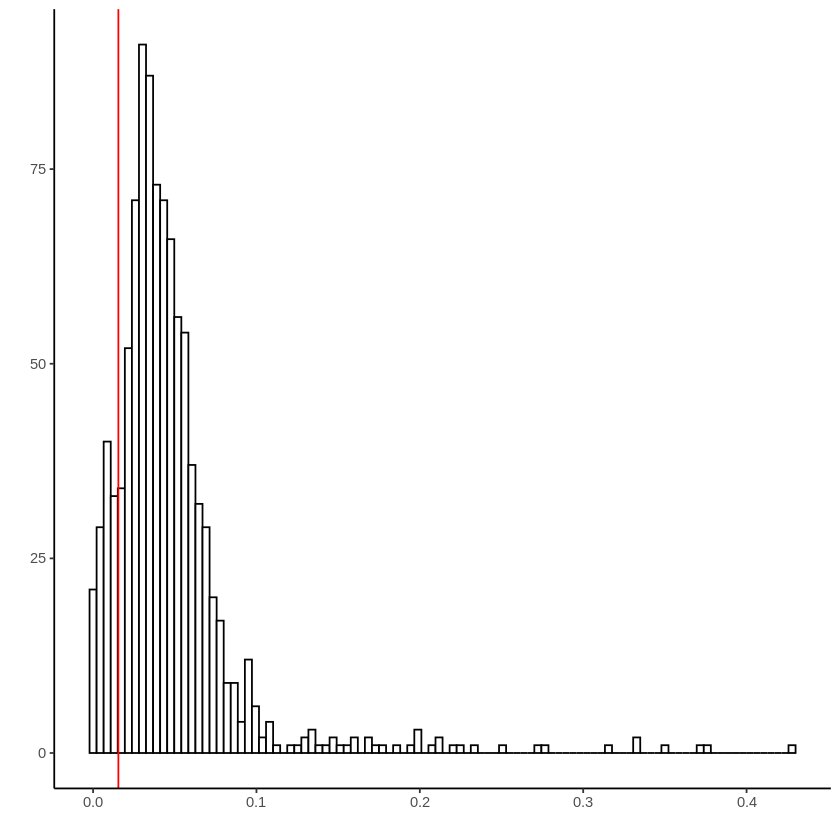

In [19]:
qplot() + 
    geom_histogram(aes(x = abs(null)), bins = 100, color = 'black', fill = 'white') + 
    geom_vline(xintercept = abs(Alb_fst), color = 'red') +
    theme_classic()

In [282]:
sum(abs(null) >= abs(Alb_diff)) / length(null)

[1] 0.119

In [100]:
set.seed(1)
test_sample <- sample_n(Alb_test, size = 2)
test_sample

city,pos,major,knownEM_r,knownEM_u,nInd_r,nInd_u,minor_r,minor_u
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
Albuquerque,CM019101.1_72957990,C,0.422755,0.503419,21,16,T,T
Albuquerque,CM019106.1_21863237,C,0.069370,0.115178,45,45,T,T


In [159]:
alb_samples <- sample_sheet %>% filter(city == 'Albuquerque')


── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  continent = col_character(),
  city = col_character(),
  pop = col_double(),
  individual = col_double(),
  site = col_character(),
  sample = col_character(),
  range = col_character(),
  library = col_character(),
  lane = col_double()
)



continent,city,pop,individual,site,sample,range,library,lane
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
NAM,Albuquerque,29,5,r,Albuquerque_29_5,Introduced,glue_low1,1
NAM,Albuquerque,29,9,r,Albuquerque_29_9,Introduced,glue_low1,1
NAM,Albuquerque,32,13,r,Albuquerque_32_13,Introduced,glue_low1,1
NAM,Albuquerque,32,3,r,Albuquerque_32_3,Introduced,glue_low1,1
NAM,Albuquerque,33,2,r,Albuquerque_33_2,Introduced,glue_low1,1
NAM,Albuquerque,33,7,r,Albuquerque_33_7,Introduced,glue_low1,1
NAM,Albuquerque,35,12,r,Albuquerque_35_12,Introduced,glue_low1,1
NAM,Albuquerque,35,3,r,Albuquerque_35_3,Introduced,glue_low1,1
NAM,Albuquerque,36,3,r,Albuquerque_36_3,Introduced,glue_low1,1
